# Mini-Project 1: Modern Low Footprint Cyber Attack Detection

### CSC 215-01 Artificial Intelligence (Fall 2019)

### Team member : 
    1) Ayushi Vadwala
    2) Jeet Shah

### Problem Formulation :   
    Software to detect network intrusions protects a computer network from unauthorized users, including perhaps insiders. This project aims to build a network intrusion detector, a predictive model capable of distinguishing between bad connections, called intrusions or attacks, and good normal connections.Model this problem as a BINARY classification problem. Use the following models to detect bad connections (intrusions).
            
### Models used to predict bad intrusions : 
    • Logistic Regression
    • Nearest Neighbor
    • Support Vector Machine
    • Fully-Connected Neural Networks

In [1]:
import collections
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd

# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, collections.Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        #Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        #Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)


In [2]:
%matplotlib inline
from sklearn.metrics import roc_curve, auc

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

#### Load training and testing data into pandas dataframe

In [3]:
import pandas as pd

train_df = pd.read_csv('data/UNSW_NB15_training-set_csc215.csv')
test_df = pd.read_csv('data/UNSW_NB15_test-set_csc215.csv')

#### After examining train and test dataset drop columns which has missing values and has nothing to do with to be predicted target

In [4]:
train_df.drop(['id','service','attack_cat', 'swin'], axis=1, inplace=True)
test_df.drop(['id','service','attack_cat', 'swin'], axis=1, inplace=True)


## Detecting OUTLIERS in Dataset

- #### As the values of column "proto" has more values of 'tcp', 'udp' and 'unas' in both training and testing dataset compared to others, others might not have more impact on target compare to 'tcp', 'udp' and 'unas' or they may be OUTLIERS. So, combine all other values except 'tcp', 'udp' and 'unas' into value called others and drop rows of that values.

In [5]:
train_df['proto'].value_counts()

tcp            79946
udp            63283
unas           12084
arp             2859
ospf            2595
sctp            1150
any              300
gre              225
ipv6             201
swipe            201
pim              201
sun-nd           201
mobile           201
rsvp             200
sep              193
ib               101
smp              100
gmtp             100
compaq-peer      100
iatp             100
wb-mon           100
iplt             100
aris             100
cpnx             100
cphb             100
mhrp             100
secure-vmtp      100
sat-expak        100
sm               100
idrp             100
               ...  
prm               99
leaf-2            99
iso-tp4           99
mux               99
trunk-1           99
ip                99
pup               99
xnet              99
leaf-1            99
cbt               99
chaos             99
emcon             99
nvp               99
xns-idp           99
trunk-2           99
dcn               99
irtp         

In [6]:
test_df['proto'].value_counts()

tcp            43095
udp            29418
unas            3515
arp              987
ospf             676
sctp             324
any               96
gre               88
rsvp              64
ipv6              61
sep               58
sun-nd            54
pim               52
mobile            52
swipe             52
bbn-rcc           34
leaf-1            34
prm               34
xns-idp           34
ip                33
leaf-2            33
iso-tp4           33
nvp               33
egp               33
hmp               33
dcn               33
st2               33
irtp              33
igp               33
mux               33
               ...  
sm                32
ptp               32
compaq-peer       32
zero              32
iatp              32
vrrp              32
a/n               32
ipv6-no           32
mtp               32
nsfnet-igp        32
ipx-n-ip          32
sprite-rpc        32
bna               32
ddx               32
pipe              32
ipcv              32
br-sat-mon   

In [7]:
considered_list = ['tcp', 'udp', 'unas']

In [8]:
def func_proto_encoding(column_value):
    if column_value in considered_list:
        return column_value
    else:
        return "others"

In [9]:
train_df['proto'] = train_df['proto'].apply(func_proto_encoding)

In [10]:
test_df['proto'] = test_df['proto'].apply(func_proto_encoding)

In [11]:
train_df = train_df[train_df['proto'] != 'others']
test_df = test_df[test_df['proto'] != "others"]

In [12]:
print(train_df['proto'].value_counts())
print(test_df['proto'].value_counts())

tcp     79946
udp     63283
unas    12084
Name: proto, dtype: int64
tcp     43095
udp     29418
unas     3515
Name: proto, dtype: int64


- **As the values of the *state* attribute mismatch in both train and test dataset, it might create issues while encoding them using one-hot encoding because of shape mismatch. Hence, we will be keeping the top 4 states in the data and will remove the rest. THEY ARE OUTLIERS.**

In [13]:
train_df['state'].value_counts()

FIN    77825
INT    63707
CON    12532
REQ     1166
RST       83
Name: state, dtype: int64

In [14]:
test_df['state'].value_counts()

FIN    39339
INT    28191
CON     6802
REQ     1690
ACC        4
RST        1
CLO        1
Name: state, dtype: int64

In [15]:
considered_state_list = ['INT', 'FIN', 'CON', 'REQ']

In [16]:
train_df_v1 = train_df[train_df['state'].isin(considered_state_list)]

In [17]:
test_df_v1 = test_df[test_df['state'].isin(considered_state_list)]

In [18]:
train_df_v1.shape

(155230, 41)

In [19]:
test_df_v1.shape

(76022, 41)

### One-hot encoding

Encoding the categorical variables proto and state (In seq: Train and Test)

In [20]:
import warnings
warnings.filterwarnings('ignore')

In [21]:
encode_text_dummy(train_df_v1,"proto")  
encode_text_dummy(train_df_v1,"state")

encode_text_dummy(test_df_v1,"proto")  
encode_text_dummy(test_df_v1,"state")

### More data preprocessing using Correlation between each feature and target

- **Correlation is obtained by dividing the covariance of the two variables by the product of their standard deviations**

### $ Correlation(x,y) = (Covariance(x,y)) / Sx * Sy $
                      
### $                  = (E[x*y] - E[x]*E[y]) / Sx * Sy $

where, E = Total sum, Sx = Standard Deviation of x, Sy = Standard Deviation of y

- We have used pandas defined corr() to find correlation and it returns series

- The correlation of a variable with itself is 1. So, which column has correlation value near to 1 has more impact on target column. Hence, we will keep columns which has correlation greater than 0.05 and will drop
others.

In [22]:
correlation_list = train_df_v1[train_df_v1.columns[:]].corr()['label']

correlation_list = [col for col in correlation_list.index if correlation_list[col] < 0.05]
print(correlation_list)

['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'stcpb', 'dtcpb', 'dwin', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'is_sm_ips_ports', 'proto-tcp', 'state-CON', 'state-FIN', 'state-REQ']


In [23]:
train_df_v2 = train_df_v1.drop(correlation_list, axis = 1)
test_df_v2 = test_df_v1.drop(correlation_list, axis = 1)

In [24]:
train_df_v2.shape

(155230, 19)

In [25]:
test_df_v2.shape

(76022, 19)

#### Splitting the data into X and y

In [26]:
X_train = train_df_v2.drop(['label'], axis = 1)
y_train = train_df_v2.loc[:, ['label']]

X_test = test_df_v2.drop(['label'], axis = 1)
y_test = test_df_v2.loc[:, ['label']]


### Feature Normalization using Z-Score

### $ Z-score (X) = ( X - MEAN ) / Standard Deviation $ 

- Z-score is the number of standard deviations from the mean a data point is. Z-score range falls between -3 (Standard Deviation) to 3 (Standard Deviation).

- We can Normalize data using **Min-Max Scaling** too but for this data, It is taking too long that's why we used Z-score.

In [27]:
X_train = X_train.astype('float')
X_test = X_test.astype('float')

In [28]:
for col in X_train.columns:
        encode_numeric_zscore(X_train,col)

for col in X_test.columns:
        encode_numeric_zscore(X_test,col)


In [29]:
target = 'label'

### Downsampling the data to make dataset less noisy

- Downsampling is the process of reducing the sampling size of the data. As per the 1st figure, We can see that data is not balanced for the target value of '0' and '1'. So, make dataset balanced we will do Downsampling and keep minimum rows among both values.

- There are more ways to do downsampling but we have used random downsampling using **numpy**'s random.shuffle method to shuffle data and keep minimum rows among both target value.


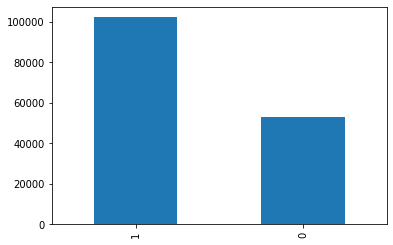

In [30]:
y_train[target].value_counts().plot(kind = 'bar')

In [31]:
index_label0 = y_train[y_train[target] == 0].index.values
index_label1 = y_train[y_train[target] == 1].index.values

labels_min_rows = min(y_train[target].value_counts())

np.random.shuffle(index_label0)
np.random.shuffle(index_label1)

index_shuffled_label0, index_shuffled_label1 = list(index_label0), list(index_label1)

indices_ = index_shuffled_label0[:labels_min_rows] + index_shuffled_label1[:labels_min_rows]


In [32]:
X_train.shape

(155230, 18)

In [33]:
X_train_ds = X_train.loc[indices_, :]

In [34]:
y_train_ds = y_train.loc[indices_, :]

### Downsampled Data

In [35]:
X_train_ds.shape

(105944, 18)

In [36]:
y_train_ds.shape

(105944, 1)

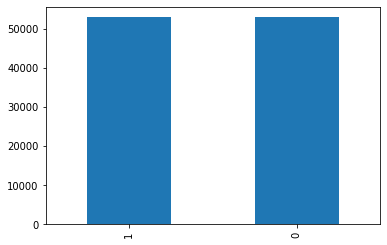

In [37]:
y_train_ds[target].value_counts().plot(kind = 'bar')

### Train model using Logistic Regression 

In [38]:
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X_train_ds.values, y_train_ds.values)

# predict the response for new observations
y_pred = logreg.predict(X_test.values)
y_pred

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

### Classification report for Logistic Rgression

In [39]:
from sklearn import metrics


score = metrics.accuracy_score(y_test, y_pred)

print("Accuracy score: {}".format(score))

Accuracy score: 0.7700928678540423


In [40]:
score = metrics.precision_score(y_test, y_pred, average= "weighted")
print("Precision score: {}".format(score))

Precision score: 0.8187862519894269


In [41]:
score = metrics.recall_score(y_test, y_pred, average= "weighted")
print("Recall score: {}".format(score))

Recall score: 0.7700928678540423


In [42]:
score = metrics.f1_score(y_test, y_pred, average= "weighted")
print("F1 score: {}".format(score))

F1 score: 0.7574814620546751


In [43]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.54      0.69     35942
           1       0.70      0.97      0.82     40080

    accuracy                           0.77     76022
   macro avg       0.83      0.76      0.75     76022
weighted avg       0.82      0.77      0.76     76022



### Confusion Matrix  for Logistic Regression

[[19568 16374]
 [ 1104 38976]]
Plotting confusion matrix


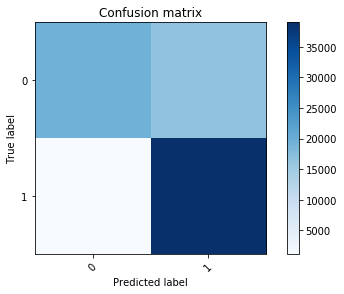

In [44]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_pred)
print(cm)


print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, [0, 1])
plt.show()

### ROC curve for Logistic Regression

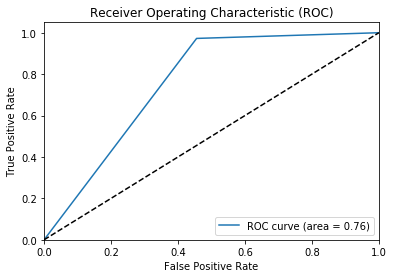

In [45]:
plot_roc(y_pred,y_test)

### Train model using SVM 

In [46]:
from sklearn import svm

#create svm classifier
cls = svm.SVC(kernel = 'rbf', gamma = 0.5)

#train
cls.fit(X_train_ds,y_train_ds)

#predict
y_pred=cls.predict(X_test)

y_pred

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

### Classification report for SVM

In [47]:
score = metrics.accuracy_score(y_test, y_pred)

print("Accuracy score: {}".format(score))

Accuracy score: 0.8351003656836179


In [48]:
score = metrics.precision_score(y_test, y_pred, average= "weighted")
print("Precision score: {}".format(score))

Precision score: 0.8493981150028478


In [49]:
score = metrics.recall_score(y_test, y_pred, average= "weighted")
print("Recall score: {}".format(score))

Recall score: 0.8351003656836179


In [50]:
score = metrics.f1_score(y_test, y_pred, average= "weighted")
print("F1 score: {}".format(score))

F1 score: 0.8322016124303879


In [51]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.71      0.80     35942
           1       0.79      0.94      0.86     40080

    accuracy                           0.84     76022
   macro avg       0.85      0.83      0.83     76022
weighted avg       0.85      0.84      0.83     76022



### Confusion Matrix and ROC curve for SVM

[[25628 10314]
 [ 2222 37858]]
Plotting confusion matrix


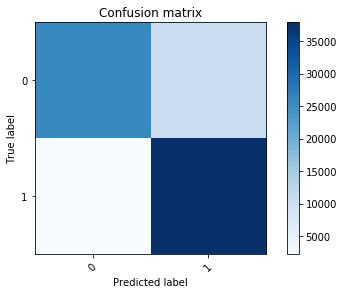

In [52]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)


print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, [0,1])
plt.show()

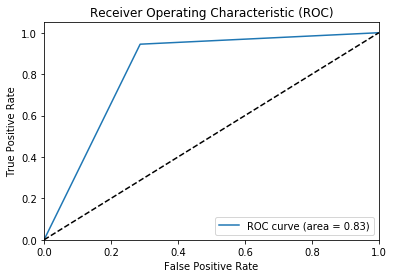

In [53]:
plot_roc(y_pred,y_test)

### Train model using KNN

In [54]:
#KNN

from sklearn.neighbors import KNeighborsClassifier

# instantiate the model (using the value K=10)
knn = KNeighborsClassifier(n_neighbors=15)

# fit the model with data
knn.fit(X_train_ds.values, y_train_ds.values)

# predict the response for new observations
y_pred = knn.predict(X_test)

y_pred

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

### Classification report , Confusion matrix and ROC curve for KNN

In [55]:
score = metrics.accuracy_score(y_test, y_pred)

print("Accuracy score: {}".format(score))

Accuracy score: 0.8259451211491411


In [56]:
score = metrics.precision_score(y_test, y_pred, average= "weighted")
print("Precision score: {}".format(score))

Precision score: 0.8317387797078515


In [57]:
score = metrics.recall_score(y_test, y_pred, average= "weighted")
print("Recall score: {}".format(score))

Recall score: 0.8259451211491411


In [58]:
score = metrics.f1_score(y_test, y_pred, average= "weighted")
print("F1 score: {}".format(score))

F1 score: 0.8243000053354083


In [59]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.74      0.80     35942
           1       0.79      0.90      0.85     40080

    accuracy                           0.83     76022
   macro avg       0.83      0.82      0.82     76022
weighted avg       0.83      0.83      0.82     76022



[[26552  9390]
 [ 3842 36238]]
Plotting confusion matrix


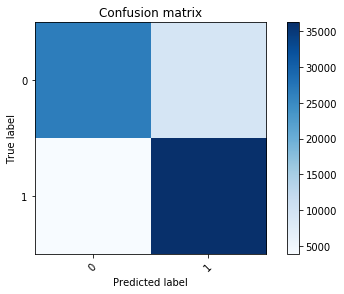

In [60]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)


print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, [0,1])
plt.show()

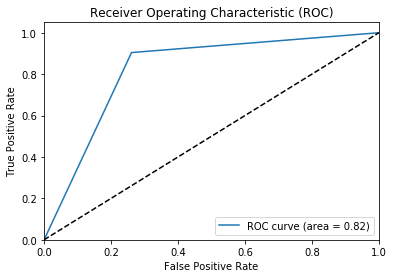

In [61]:
plot_roc(y_pred,y_test)

### Neural Network

**One-hot encoding target column using pandas in-built method "get_dummies"
  because Binary classification Neural Network accept 2-d array of output vector**

In [62]:
y_train_ds1 = pd.get_dummies(y_train_ds[target])

In [63]:
y_test = test_df_v2.loc[:, ['label']]

In [64]:
y_test_tf = pd.get_dummies(y_test[target])

In [65]:
X_train_ds.shape

(105944, 18)

In [66]:
y_train_ds1.shape

(105944, 2)

In [67]:
X_test.shape

(76022, 18)

In [68]:
y_test_tf.shape

(76022, 2)

### Training Neural Network using Sequential model with the use of Hidden layers, EarlyStopping and ModelCheckpoint

In [70]:
import io
import requests
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
save_path = "./dnn/"

model = Sequential()

#Tuning Hyperparameters to achieve best model and to improve performance
model.add(Dense(50, input_dim=X_train_ds.shape[1], activation='relu'))
model.add(Dense(25,activation='relu'))
model.add(Dense(15,activation='relu'))
model.add(Dense(y_train_ds1.shape[1],activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10, verbose=2, mode='auto') 

checkpointer = ModelCheckpoint(filepath="dnn/network.hdf5", verbose=0, save_best_only=True) # save best model

model.fit(X_train_ds, y_train_ds1, validation_data=(X_test,y_test_tf), callbacks=[monitor], verbose=2, epochs=100)  

model.load_weights('dnn/network.hdf5') # load weights from best model
#model.save(os.path.join(save_path,"network1.hdf5"))

Train on 105944 samples, validate on 76022 samples
Epoch 1/100
105944/105944 - 5s - loss: 0.1827 - acc: 0.9087 - val_loss: 0.3356 - val_acc: 0.8136
Epoch 2/100
105944/105944 - 5s - loss: 0.1628 - acc: 0.9173 - val_loss: 0.3237 - val_acc: 0.8288
Epoch 3/100
105944/105944 - 5s - loss: 0.1595 - acc: 0.9194 - val_loss: 0.3111 - val_acc: 0.8381
Epoch 4/100
105944/105944 - 5s - loss: 0.1578 - acc: 0.9195 - val_loss: 0.3470 - val_acc: 0.8134
Epoch 5/100
105944/105944 - 5s - loss: 0.1563 - acc: 0.9212 - val_loss: 0.3232 - val_acc: 0.8152
Epoch 6/100
105944/105944 - 5s - loss: 0.1548 - acc: 0.9215 - val_loss: 0.2980 - val_acc: 0.8471
Epoch 7/100
105944/105944 - 5s - loss: 0.1542 - acc: 0.9217 - val_loss: 0.3359 - val_acc: 0.8312
Epoch 8/100
105944/105944 - 5s - loss: 0.1535 - acc: 0.9217 - val_loss: 0.3082 - val_acc: 0.8309
Epoch 9/100
105944/105944 - 5s - loss: 0.1529 - acc: 0.9225 - val_loss: 0.3536 - val_acc: 0.8071
Epoch 10/100
105944/105944 - 5s - loss: 0.1522 - acc: 0.9231 - val_loss: 0.3

In [71]:
y_pred = model.predict(X_test)

In [72]:
y_pred = np.argmax(y_pred,axis=1) # raw probabilities to choose class (highest probability)
print(y_pred)

[1 1 1 ... 1 1 1]


In [73]:
y_test = np.argmax(y_test_tf.values, axis = 1)
print(y_test)

[0 0 0 ... 0 0 0]


### Classification report , Confusion matrix and ROC curve for Neural Network

In [74]:
score = metrics.accuracy_score(y_test, y_pred)

print("Accuracy score: {}".format(score))

Accuracy score: 0.8287206335008287


In [75]:
score = metrics.precision_score(y_test, y_pred, average= "weighted")
print("Precision score: {}".format(score))

Precision score: 0.8490009553492743


In [76]:
score = metrics.recall_score(y_test, y_pred, average= "weighted")
print("Recall score: {}".format(score))

Recall score: 0.8287206335008287


In [77]:
score = metrics.f1_score(y_test, y_pred, average= "weighted")
print("F1 score: {}".format(score))

F1 score: 0.824720395549406


In [78]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.69      0.79     35942
           1       0.77      0.96      0.85     40080

    accuracy                           0.83     76022
   macro avg       0.85      0.82      0.82     76022
weighted avg       0.85      0.83      0.82     76022



[[24659 11283]
 [ 1738 38342]]
Plotting confusion matrix


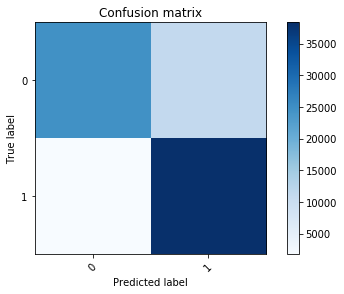

In [79]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)


print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, [0,1])
plt.show()

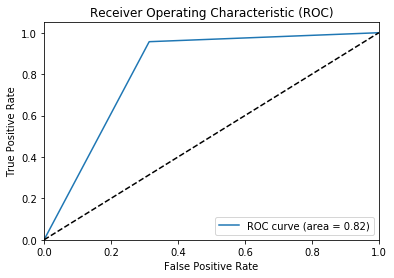

In [80]:
plot_roc(y_pred,y_test)

## Additional Feature Implementation

### Intrusion Detection as a Multi-class classification problem to detect the type of each intrusion

- **Preprocessed dataset as described above with change of target from 'label' to 'attack_cat'**

- **Since each attack category has different value_counts and we can not just ignore minimum number of value_counts. So, we can not apply downsampling of dataset for Multi-class classification problem**

In [81]:
import pandas as pd

train_df_a1 = pd.read_csv('data/UNSW_NB15_training-set_csc215.csv')
test_df_a1 = pd.read_csv('data/UNSW_NB15_test-set_csc215.csv')

In [82]:
train_df_a1.drop(['id','service','label', 'swin'], axis=1, inplace=True)
test_df_a1.drop(['id','service','label', 'swin'], axis=1, inplace=True)

In [83]:
considered_list = ['tcp', 'udp', 'unas']

In [84]:
def func_proto_encoding(column_value):
    if column_value in considered_list:
        return column_value
    else:
        return "others"

In [85]:
train_df_a1['proto'] = train_df_a1['proto'].apply(func_proto_encoding)

test_df_a1['proto'] = test_df_a1['proto'].apply(func_proto_encoding)

In [86]:
considered_state_list = ['INT', 'FIN', 'CON', 'REQ']

train_df_a1_v1 = train_df_a1[train_df_a1['state'].isin(considered_state_list)]

test_df_a1_v1 = test_df_a1[test_df_a1['state'].isin(considered_state_list)]

In [87]:
encode_text_dummy(train_df_a1_v1,"proto")  
encode_text_dummy(train_df_a1_v1,"state")

encode_text_dummy(test_df_a1_v1,"proto")  
encode_text_dummy(test_df_a1_v1,"state")

#### Since attack_cat column has different categorical values, We have to Encode that categorical values to index.

In [88]:
encode_text_index(train_df_a1_v1,"attack_cat")
encode_text_index(test_df_a1_v1,"attack_cat")

array(['Analysis', 'Backdoor', 'DoS', 'Exploits', 'Fuzzers', 'Generic',
       'Normal', 'Reconnaissance', 'Shellcode', 'Worms'], dtype=object)

In [89]:
correlation_list = train_df_a1_v1[train_df_a1_v1.columns[:]].corr()['attack_cat']

correlation_list = [col for col in correlation_list.index if correlation_list[col] < 0.01 and correlation_list[col] > -0.01]
print(correlation_list)

['spkts', 'dinpkt', 'sjit', 'djit', 'response_body_len']


In [90]:
train_df_a1_v2 = train_df_a1_v1.drop(correlation_list, axis = 1)
test_df_a1_v2 = test_df_a1_v1.drop(correlation_list, axis = 1)

In [91]:
X_train_a1 = train_df_a1_v2.drop(['attack_cat'], axis = 1)
y_train_a1 = train_df_a1_v2.loc[:, ['attack_cat']]

X_test_a1 = test_df_a1_v2.drop(['attack_cat'], axis = 1)
y_test_a1 = test_df_a1_v2.loc[:, ['attack_cat']]


In [92]:
X_train_a1 = X_train_a1.astype('float')
X_test_a1 = X_test_a1.astype('float')

In [93]:
for col in X_train_a1.columns:
        encode_numeric_zscore(X_train_a1,col)

for col in X_test_a1.columns:
        encode_numeric_zscore(X_test_a1,col)


In [94]:
target = 'attack_cat'

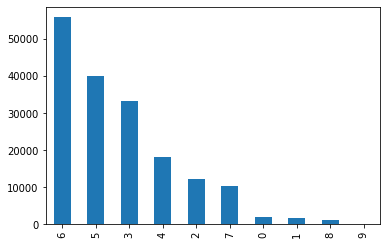

In [95]:
y_train_a1[target].value_counts().plot(kind = 'bar')

In [96]:
y_train_a1 = pd.get_dummies(y_train_a1[target])

In [97]:
y_test_a1 = test_df_a1_v2.loc[:, ['attack_cat']]

In [98]:
y_test_a1_tf = pd.get_dummies(y_test_a1[target])

In [99]:
X_train_a1.shape

(175243, 41)

In [100]:
y_train_a1.shape

(175243, 10)

In [101]:
X_test_a1.shape

(82326, 41)

In [102]:
y_test_a1_tf.shape

(82326, 10)

In [103]:
import io
import requests
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
save_path = "./dnn/"

model = Sequential()

#Tuning Hyperparameters to achieve best model and to improve performance
model.add(Dense(50, input_dim=X_train_a1.shape[1], activation='relu'))
model.add(Dense(25,activation='relu'))
model.add(Dense(15,activation='relu'))
model.add(Dense(y_train_a1.shape[1],activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10, verbose=2, mode='auto') 

checkpointer = ModelCheckpoint(filepath="dnn/network1.hdf5", verbose=0, save_best_only=True) # save best model

model.fit(X_train_a1, y_train_a1, validation_data=(X_test_a1,y_test_a1_tf), callbacks=[monitor], verbose=2, epochs=100)  

model.load_weights('dnn/network1.hdf5') # load weights from best model
# save entire network to HDF5 (save everything)
#model.save(os.path.join(save_path,"network1.hdf5"))

Train on 175243 samples, validate on 82326 samples
Epoch 1/100
175243/175243 - 8s - loss: 0.6323 - acc: 0.7612 - val_loss: 0.7187 - val_acc: 0.6845
Epoch 2/100
175243/175243 - 7s - loss: 0.5530 - acc: 0.7845 - val_loss: 0.6783 - val_acc: 0.7070
Epoch 3/100
175243/175243 - 8s - loss: 0.5354 - acc: 0.7903 - val_loss: 0.6715 - val_acc: 0.7151
Epoch 4/100
175243/175243 - 7s - loss: 0.5256 - acc: 0.7941 - val_loss: 0.6720 - val_acc: 0.7154
Epoch 5/100
175243/175243 - 7s - loss: 0.5184 - acc: 0.7953 - val_loss: 0.7188 - val_acc: 0.6915
Epoch 6/100
175243/175243 - 7s - loss: 0.5120 - acc: 0.7975 - val_loss: 0.7041 - val_acc: 0.6879
Epoch 7/100
175243/175243 - 7s - loss: 0.5070 - acc: 0.7986 - val_loss: 0.8010 - val_acc: 0.6652
Epoch 8/100
175243/175243 - 7s - loss: 0.5018 - acc: 0.8003 - val_loss: 0.7211 - val_acc: 0.6806
Epoch 9/100
175243/175243 - 8s - loss: 0.4983 - acc: 0.8009 - val_loss: 0.8184 - val_acc: 0.6616
Epoch 10/100
175243/175243 - 7s - loss: 0.4946 - acc: 0.8017 - val_loss: 0.9

In [104]:
y_pred_a1 = model.predict(X_test_a1)

In [105]:
y_pred_a1 = np.argmax(y_pred_a1,axis=1) # raw probabilities to choose class (highest probability)
print(y_pred_a1)

[4 4 4 ... 6 6 2]


In [106]:
y_test_a1 = np.argmax(y_test_a1_tf.values, axis = 1)
print(y_test_a1)

[6 6 6 ... 6 6 6]


In [107]:
print(metrics.classification_report(y_test_a1, y_pred_a1))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       677
           1       0.10      0.01      0.01       583
           2       0.31      0.03      0.05      4089
           3       0.54      0.92      0.68     11131
           4       0.21      0.66      0.32      6061
           5       0.98      0.79      0.87     18871
           6       0.94      0.63      0.75     36997
           7       0.66      0.69      0.68      3495
           8       0.63      0.14      0.23       378
           9       0.50      0.05      0.08        44

    accuracy                           0.67     82326
   macro avg       0.49      0.39      0.37     82326
weighted avg       0.78      0.67      0.69     82326



[[    0     0    23   606     0     0    48     0     0     0]
 [    0     3    24   532    16     1     1     6     0     0]
 [    0     8   109  3728   166    21    24    29     4     0]
 [   19     5    92 10237   648     3    92    30     5     0]
 [    0     0    50  1297  4005     9   472   227     1     0]
 [    0     1    13   493  2588 14897   865     8     4     2]
 [  449     6    31  1053 11120   188 23268   864    18     0]
 [    0     2     4   813   204    40     4  2428     0     0]
 [    0     4     0    60   144    22     2    92    54     0]
 [    0     0     1    32     6     2     1     0     0     2]]
Plotting confusion matrix


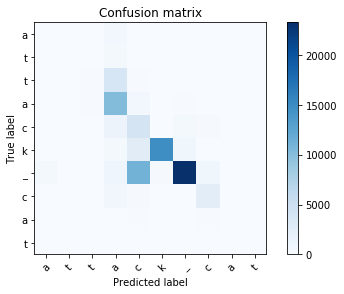

In [108]:
# Compute confusion matrix
cm = confusion_matrix(y_test_a1, y_pred_a1)
print(cm)


print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, target)
plt.show()

### Top-10 Features

In [109]:
import pandas as pd

train_df_a2 = pd.read_csv('data/UNSW_NB15_training-set_csc215.csv')
test_df_a2 = pd.read_csv('data/UNSW_NB15_test-set_csc215.csv')

In [110]:
train_df_a2.drop(['id','service','attack_cat'], axis=1, inplace=True)
test_df_a2.drop(['id','service','attack_cat'], axis=1, inplace=True)

In [111]:
considered_list = ['tcp', 'udp', 'unas']

In [112]:
def func_proto_encoding(column_value):
    if column_value in considered_list:
        return column_value
    else:
        return "others"

In [113]:
train_df_a2['proto'] = train_df_a2['proto'].apply(func_proto_encoding)

test_df_a2['proto'] = test_df_a2['proto'].apply(func_proto_encoding)

In [114]:
considered_state_list = ['INT', 'FIN', 'CON', 'REQ']

train_df_a2_v1 = train_df_a2[train_df_a2['state'].isin(considered_state_list)]

test_df_a2_v1 = test_df_a2[test_df_a2['state'].isin(considered_state_list)]

In [115]:
encode_text_dummy(train_df_a2_v1,"proto")  
encode_text_dummy(train_df_a2_v1,"state")

encode_text_dummy(test_df_a2_v1,"proto")  
encode_text_dummy(test_df_a2_v1,"state")

In [116]:
correlation_list_a2 = train_df_a2_v1[train_df_a2_v1.columns[:]].corr()['label']

correlation_list_a2 = correlation_list_a2.sort_values(ascending = False)

In [117]:
correlation_list_a21 = correlation_list_a2[0:10]

In [118]:
correlation_list_a21 = [col for col in correlation_list_a21.index]

In [119]:
correlation_list_a22 = correlation_list_a2[10:]

In [120]:
correlation_list_a22 = [col for col in correlation_list_a22.index]

In [121]:
correlation_list_a21

['label',
 'sttl',
 'ct_state_ttl',
 'state-INT',
 'ct_dst_sport_ltm',
 'rate',
 'ct_src_dport_ltm',
 'ct_dst_src_ltm',
 'ct_src_ltm',
 'ct_dst_ltm']

In [122]:
correlation_list_a22

['ct_srv_src',
 'ct_srv_dst',
 'proto-unas',
 'sload',
 'proto-udp',
 'proto-others',
 'ackdat',
 'dttl',
 'tcprtt',
 'synack',
 'dur',
 'sbytes',
 'ct_flw_http_mthd',
 'trans_depth',
 'sloss',
 'sjit',
 'smean',
 'is_ftp_login',
 'ct_ftp_cmd',
 'response_body_len',
 'dinpkt',
 'state-REQ',
 'spkts',
 'djit',
 'dbytes',
 'dloss',
 'dpkts',
 'sinpkt',
 'is_sm_ips_ports',
 'dtcpb',
 'stcpb',
 'state-FIN',
 'dwin',
 'swin',
 'proto-tcp',
 'dmean',
 'state-CON',
 'dload']

In [123]:
train_df_a2_v2 = train_df_a2_v1.drop(correlation_list_a22, axis = 1)
test_df_a2_v2 = test_df_a2_v1.drop(correlation_list_a22, axis = 1)

In [124]:
X_train_a2 = train_df_a2_v2.drop(['label'], axis = 1)
y_train_a2 = train_df_a2_v2.loc[:, ['label']]

X_test_a2 = test_df_a2_v2.drop(['label'], axis = 1)
y_test_a2 = test_df_a2_v2.loc[:, ['label']]


In [125]:
X_train_a2 = X_train_a2.astype('float')
X_test_a2 = X_test_a2.astype('float')

In [126]:
for col in X_train_a2.columns:
        encode_numeric_zscore(X_train_a2,col)

for col in X_test_a2.columns:
        encode_numeric_zscore(X_test_a2,col)


In [127]:
target = 'label'

In [128]:
y_train_a2 = pd.get_dummies(y_train_a2[target])

In [129]:
y_test_a2 = test_df_a2_v2.loc[:, ['label']]

In [130]:
y_test_a2_tf = pd.get_dummies(y_test_a2[target])

In [131]:
import io
import requests
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
save_path = "./dnn/"

model = Sequential()

#Tuning Hyperparameters to achieve best model and to improve performance
model.add(Dense(50, input_dim=X_train_a2.shape[1], activation='relu'))
model.add(Dense(25,activation='relu'))
model.add(Dense(15,activation='relu'))
model.add(Dense(y_train_a2.shape[1],activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10, verbose=2, mode='auto') 

checkpointer = ModelCheckpoint(filepath="dnn/network2.hdf5", verbose=0, save_best_only=True) # save best model

model.fit(X_train_a2, y_train_a2, validation_data=(X_test_a2,y_test_a2_tf), callbacks=[monitor], verbose=2, epochs=100)  

model.load_weights('dnn/network2.hdf5') # load weights from best model
# save entire network to HDF5 (save everything)
#model.save(os.path.join(save_path,"network2.hdf5"))

Train on 175243 samples, validate on 82326 samples
Epoch 1/100
175243/175243 - 7s - loss: 0.1677 - acc: 0.9290 - val_loss: 0.3755 - val_acc: 0.8414
Epoch 2/100
175243/175243 - 7s - loss: 0.1503 - acc: 0.9329 - val_loss: 0.3613 - val_acc: 0.8453
Epoch 3/100
175243/175243 - 7s - loss: 0.1470 - acc: 0.9336 - val_loss: 0.3762 - val_acc: 0.8207
Epoch 4/100
175243/175243 - 7s - loss: 0.1456 - acc: 0.9342 - val_loss: 0.3564 - val_acc: 0.8110
Epoch 5/100
175243/175243 - 8s - loss: 0.1441 - acc: 0.9343 - val_loss: 0.4111 - val_acc: 0.8087
Epoch 6/100
175243/175243 - 7s - loss: 0.1432 - acc: 0.9351 - val_loss: 0.3585 - val_acc: 0.8091
Epoch 7/100
175243/175243 - 7s - loss: 0.1425 - acc: 0.9353 - val_loss: 0.3618 - val_acc: 0.8170
Epoch 8/100
175243/175243 - 7s - loss: 0.1420 - acc: 0.9357 - val_loss: 0.3769 - val_acc: 0.8271
Epoch 9/100
175243/175243 - 8s - loss: 0.1415 - acc: 0.9361 - val_loss: 0.3785 - val_acc: 0.8123
Epoch 10/100
175243/175243 - 7s - loss: 0.1408 - acc: 0.9362 - val_loss: 0.3

In [132]:
y_pred_a2 = model.predict(X_test_a2)

In [133]:
y_pred_a2 = np.argmax(y_pred_a2,axis=1) # raw probabilities to choose class (highest probability)
print(y_pred_a2)

[1 1 1 ... 1 1 1]


In [134]:
y_test_a2 = np.argmax(y_test_a2_tf.values, axis = 1)
print(y_test_a2)

[0 0 0 ... 0 0 0]


In [135]:
print(metrics.classification_report(y_test_a2, y_pred_a2))

              precision    recall  f1-score   support

           0       1.00      0.54      0.70     36997
           1       0.73      1.00      0.84     45329

    accuracy                           0.79     82326
   macro avg       0.86      0.77      0.77     82326
weighted avg       0.85      0.79      0.78     82326



[[20094 16903]
 [   90 45239]]
Plotting confusion matrix


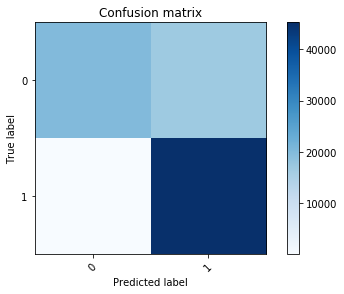

In [136]:
# Compute confusion matrix
cm = confusion_matrix(y_test_a2, y_pred_a2)
print(cm)


print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, [0,1])
plt.show()

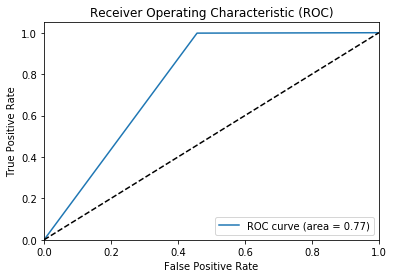

In [137]:
plot_roc(y_pred_a2,y_test_a2)